# Finding Errors in the Conll 2003 NER dataset

In this notebook, we'll walk through identifying potential errors in the Conll 2003 NER dataset.
We'll load up the Conll data into Recon using the huggingface [datasets](https://huggingface.co/docs/datasets/index) library and walk through a standard debugging process with Recon.

We'll discuss:

1. Stats
2. Entity Coverage
3. Label Disparities
4. Prediction Errors
5. Hardest Examples

First, lets load up the Corpus using the `load_dataset` function from `datasets` and the `Dataset.from_hf_dataset` loader in Recon

In [1]:
from recon import Corpus, Dataset
from recon.stats import get_ner_stats, get_entity_coverage
from recon.insights import get_label_disparities, top_label_disparities

In [2]:
from datasets.load import load_dataset
from datasets.arrow_dataset import Dataset as HFDataset

/Users/kabirkhan/Documents/recon/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
conll2003 = load_dataset("conll2003")

Generating test split: 100%|████████████████████████████████████████████████| 3453/3453 [00:00<00:00, 13750.50 examples/s]


In [4]:
conll_labels = ["O", "B-PER", "I-PER", "B-ORG", "I-ORG", "B-LOC", "I-LOC", "B-MISC", "I-MISC"]

In [5]:
train_ds = Dataset("train").from_hf_dataset(conll2003["train"], labels=conll_labels)
dev_ds = Dataset("dev").from_hf_dataset(conll2003["validation"], labels=conll_labels)
test_ds = Dataset("test").from_hf_dataset(conll2003["test"], labels=conll_labels)

In [6]:
corpus = Corpus("conll2003", train_ds, dev_ds, test_ds)

## 1. Stats

First we'll look at the basic stats of the each split in the Corpus using `Corpus.print_summary`. 
Under the hood, `summary` runs the `recon.stats.get_ner_stats` function across each Dataset

In [7]:
corpus.print_summary()

Dataset
Name: train
Stats: {
    "n_examples": 14041,
    "n_examples_no_entities": 2909,
    "n_annotations": 23499,
    "n_annotations_per_type": {
        "LOC": 7140,
        "PER": 6600,
        "ORG": 6321,
        "MISC": 3438
    }
}
Dataset
Name: dev
Stats: {
    "n_examples": 3250,
    "n_examples_no_entities": 645,
    "n_annotations": 5942,
    "n_annotations_per_type": {
        "PER": 1842,
        "LOC": 1837,
        "ORG": 1341,
        "MISC": 922
    }
}
Dataset
Name: test
Stats: {
    "n_examples": 3453,
    "n_examples_no_entities": 697,
    "n_annotations": 5648,
    "n_annotations_per_type": {
        "LOC": 1668,
        "ORG": 1661,
        "PER": 1617,
        "MISC": 702
    }
}


Just based on the stats above, we'd probably expect our model to do better on the `LOC` label than the `MISC` label since we have almost twice the labels for `LOC`.

Let's dive into dataset statistics a bit more granularly and look at Entity Coverage

## 2. Entity Coverage

Entity Coverage looks at individual annotation spans and aggregates and sorts them. Looking at the extremes (start and end) for the Entity Coverage can tell you a lot about your Dataset.

In [11]:
train_ecs = get_entity_coverage(corpus.train, case_sensitive=True)

**Most** covered entity spans

It's no surprise that common locations are our most covered entity spans. If we train a model, we'd expect these entities to be easy to identify.

In [12]:
train_ecs[:10]

[EntityCoverage(text='U.S.', label='LOC', count=303),
 EntityCoverage(text='Germany', label='LOC', count=141),
 EntityCoverage(text='Britain', label='LOC', count=133),
 EntityCoverage(text='Australia', label='LOC', count=130),
 EntityCoverage(text='England', label='LOC', count=123),
 EntityCoverage(text='France', label='LOC', count=122),
 EntityCoverage(text='Spain', label='LOC', count=110),
 EntityCoverage(text='Italy', label='LOC', count=98),
 EntityCoverage(text='LONDON', label='LOC', count=93),
 EntityCoverage(text='Russian', label='MISC', count=92)]

**Least** covered entity spans
It's also no surprise that Person names are in our least covered entities

In [13]:
train_ecs[-10:]

[EntityCoverage(text='Luca Cadalora', label='PER', count=1),
 EntityCoverage(text='Alex Criville', label='PER', count=1),
 EntityCoverage(text='Scott Russell', label='PER', count=1),
 EntityCoverage(text='Tadayuki Okada', label='PER', count=1),
 EntityCoverage(text='Carlos Checa', label='PER', count=1),
 EntityCoverage(text='Alexandre Barros', label='PER', count=1),
 EntityCoverage(text='Shinichi Itoh', label='PER', count=1),
 EntityCoverage(text='Swe', label='LOC', count=1),
 EntityCoverage(text='Bob May', label='PER', count=1),
 EntityCoverage(text='Bradley Hughes', label='PER', count=1)]

## Label Disparities (sometimes 1 label, sometimes another)

In [57]:
lds = top_label_disparities(corpus.train)

In [58]:
lds

[LabelDisparity(label1='ORG', label2='LOC', count=93, examples=[]),
 LabelDisparity(label1='LOC', label2='ORG', count=93, examples=[]),
 LabelDisparity(label1='ORG', label2='PER', count=16, examples=[]),
 LabelDisparity(label1='PER', label2='ORG', count=16, examples=[]),
 LabelDisparity(label1='PER', label2='LOC', count=12, examples=[]),
 LabelDisparity(label1='LOC', label2='PER', count=12, examples=[]),
 LabelDisparity(label1='MISC', label2='LOC', count=7, examples=[]),
 LabelDisparity(label1='LOC', label2='MISC', count=7, examples=[]),
 LabelDisparity(label1='ORG', label2='MISC', count=6, examples=[]),
 LabelDisparity(label1='MISC', label2='ORG', count=6, examples=[]),
 LabelDisparity(label1='MISC', label2='PER', count=1, examples=[]),
 LabelDisparity(label1='PER', label2='MISC', count=1, examples=[])]

In [37]:
from typing import List, Tuple
import numpy as np
import seaborn as sns
from recon.types import LabelDisparity

def plot_cm(cm: np.array, labels: List[str]):
    labels = np.asarray(list(labels))
    print(cm, labels)
    return sns.heatmap(cm, annot=True, xticklabels=labels, yticklabels=labels, cmap="Blues")

def get_lds_cm(label_disparities: List[LabelDisparity]) -> Tuple[List[str], np.array]:
    labels = set()
    for ld in lds:
        labels.add(ld.label1)
        labels.add(ld.label2)
    labels_map = {l:i for i, l in enumerate(labels)}
    K = len(labels)
    result = np.zeros((K, K))
    for ld in lds:
        result[labels_map[ld.label1]][labels_map[ld.label2]] = ld.count
    return labels, result

[[ 0.  7. 12. 93.]
 [ 7.  0.  1.  6.]
 [12.  1.  0. 16.]
 [93.  6. 16.  0.]] ['LOC' 'MISC' 'PER' 'ORG']


<Axes: >

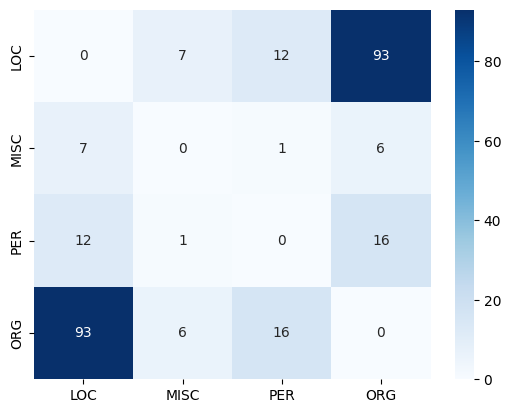

In [38]:
labels, cm = get_lds_cm(lds)
plot_cm(cm, labels=labels)

In [41]:
corpus.to_disk("./data/conll2003", overwrite=True)

In [42]:
corpus.train_ds.to_spacy("./data/conll2003")
corpus.dev_ds.to_spacy("./data/conll2003")

In [44]:
!spacy download en_core_web_md
!spacy train config/config.cfg \
    --paths.train ./data/conll2003/train.spacy \
    --paths.dev ./data/conll2003/dev.spacy \
    --paths.vectors "en_core_web_md" \
    --output ./models/en_conll_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 9.6 MB/s eta 0:00:00m eta 0:00:010:00:01m

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
ℹ Saving to output directory: models/en_conll_md
ℹ Using CPU

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     44.28    0.00    0.00    0.00    0.00
  0     200         82.58   2838.65   52.41   60.56   46.20    0.52
  0     400       1039.30   2465.74   63.43   64.10   62.77    0.63
  0     600        256.40   2220.14   71.76 

In [45]:
import spacy
from recon.insights import top_prediction_errors, get_hardest_examples
from recon.recognizer import SpacyEntityRecognizer

In [46]:
nlp = spacy.load("models/en_conll_md/model-best/")
rec = SpacyEntityRecognizer(nlp)

In [50]:
pe = top_prediction_errors(rec, corpus.dev)
pe[:10]

[PredictionError(text='Pirelli', true_label='ORG', pred_label='PER', count=9),
 PredictionError(text='Suu Kyi', true_label='PER', pred_label='ORG', count=9),
 PredictionError(text="Boatmen 's", true_label='ORG', pred_label='NOT_LABELED', count=7),
 PredictionError(text='Washington', true_label='PER', pred_label='LOC', count=6),
 PredictionError(text='Bernardin', true_label='PER', pred_label='NOT_LABELED', count=6),
 PredictionError(text='Jansher', true_label='PER', pred_label='LOC', count=6),
 PredictionError(text='King', true_label='PER', pred_label='NOT_LABELED', count=6),
 PredictionError(text='Boatmen', true_label='NOT_LABELED', pred_label='PER', count=6),
 PredictionError(text='Magna', true_label='ORG', pred_label='NOT_LABELED', count=5),
 PredictionError(text='Lukashenko', true_label='PER', pred_label='ORG', count=5)]

In [85]:
train_hes = get_hardest_examples(rec, corpus.train)

In [90]:
dev_hes = get_hardest_examples(rec, corpus.dev)

In [86]:
test_hes = get_hardest_examples(rec, corpus.test)

In [97]:
idx = 0
train_hes[idx].reference.show()
train_hes[idx].prediction.show()

In [91]:
idx = 0
dev_hes[idx].reference.show()
dev_hes[idx].prediction.show()

In [92]:
idx=0
test_hes[idx].reference.show()
test_hes[idx].prediction.show()

In [95]:
china_he = [he for he in test_hes if "CHINA" in he.reference.text][0]
china_he.reference.show()
china_he.prediction.show()

In [22]:
from spacy.tokens import Doc
from spacy.util import get_words_and_spaces
from spacy.vocab import Vocab
from recon.types import HardestExample
from spacy import displacy

def he_show(he: HardestExample, label_suffix: str = "PRED"):
    
    combined = he.reference.copy(deep=True)
    pred_spans = []
    for s in he.prediction.spans:
        span = s.copy(deep=True)
        span.label = f"{s.label}:{label_suffix}"
        pred_spans.append(span)

    combined.spans = sorted(combined.spans + pred_spans, key=lambda s: s.start)
    
    tokens = [token.text for token in combined.tokens]
    words, spaces = get_words_and_spaces(tokens, combined.text)
    doc = Doc(Vocab(), words=words, spaces=spaces)
    doc.spans["ref"] = [doc.char_span(s.start, s.end, label=s.label) for s in combined.spans]
    displacy.render(doc, style="span", jupyter=True, options={"spans_key": "ref"})


he_show(he[0])

In [23]:
corpus.dev_ds.to_prodigy()

Saving dataset to prodigy dataset: dev_671418edc919b3e9


'dev_671418edc919b3e9'

In [26]:
!prodigy recon.ner_correct conll_he ./models/en_conll_sm/model-best dataset:dev_671418edc919b3e9

/Users/kabirkhan/Library/Caches/pypoetry/virtualenvs/reconner-cI2LIzZM-py3.10/lib/python3.10/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_pipeline' (0.0.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.3.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
Using 4 labels from model: LOC, MISC, ORG, PER

✨  Starting the web server at http://localhost:8080 ...
Open the app in your browser and start annotating!

^C
